# BTCUSD Dataset 1

In [1]:
import pandas as pd 
import numpy as np
import talib as ta

import os
import pickle

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

import xgboost as xgb

import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
import sklearn.mixture as mix

import shap
import lime

from PIL import Image

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

from math import sqrt
sqn = lambda x: round(sqrt(sum(~np.isnan(x))) * np.nanmean(x) / np.nanstd(x), 4)
open_close_change = lambda Open, Close: (Close - Open) / Open 

Using TensorFlow backend.


In [2]:
# Function for resampling OHLC data

def resample_ohlc(df, interval = '4H'):

    df_open = df.resample(interval, base = 4)['Open'].first()
    df_high = df.resample(interval, base = 4)['High'].max()
    df_low = df.resample(interval, base = 4)['Low'].min()
    df_close = df.resample(interval, base = 4)['Close'].last()
    df_volume = df.resample(interval, base = 4)['Volume'].sum()
    df = pd.concat([df_open, df_high, df_low, df_close, df_volume], axis = 1)
    
    return df.dropna()



def process_data(df, indicators = ['AOP', 'open_close_change'], n_components = 5):

    filter_indicators = [x for x in indicators] + ['open_close_change']
        
    idx = df[filter_indicators].dropna().index
    X = df[filter_indicators].dropna().values
    
    model = mix.GaussianMixture(n_components = n_components, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)
    
    hidden_states = model.predict(X)
    
    # Compose into dataframes and join together; return 
    df_hidden_states = pd.DataFrame(hidden_states, index = idx, columns = ['hidden_state'])
    return df.join(df_hidden_states, how = 'inner')

### Creating different datasets to test

I'd like to try the machine learning workflow using a few different test datasets... where each dataset uses a different number of indicators and GMM "components" to create the data

In [5]:
if not os.path.exists("BTCUSD_Dataset1.csv"):
    # Read local data file 
    df_data = pd.read_csv('BTC_4H_historical.csv', error_bad_lines = False)
    
    # Check to make sure we have a column for time
    if 'Time' not in df_data.columns:
        df_data['Time'] = pd.to_datetime(df_data['Unnamed: 0'])
        df_data.drop(columns = ['Unnamed: 0'], inplace = True)

    # Convert time to datetime format and set as index
    df_data['Time'] = pd.to_datetime(df_data['Time'])
    df_data.set_index('Time', inplace = True)
    
    # Capitalize first letters of column headers 
    df_data.columns = df_data.columns.str.capitalize()
    
    # Resample the data for 4-hr OHLC bars

    # df_data = resample_ohlc(df_data)

    # Calculate the PnL for the candle from open to close

    df_data['open_close_change'] = df_data.apply(lambda x: open_close_change(x['Open'], x['Close']), axis = 1)

    df_data1 = df_data.copy()

    # Add the indicators to df_data1
    df_data1['APO'] = ta.APO(df_data['Close']).shift()
    k, d = ta.STOCH(df_data['High'], df_data['Low'], df_data['Close'])
    df_data1['STOCH'] = (k-d).shift()
    k, d = ta.STOCHRSI(df_data['Close'])
    df_data1['STOCHRSI'] = (k-d).shift()

    # Define the number of regimes the GMM model will be identifying
    n_components_data1 = 5

    # Define indicator names for the GMM function
    indicators_data1 = ['APO', 'STOCH', 'STOCHRSI']

    # Dataset1
    dataset1 = process_data(df_data1, indicators_data1, n_components_data1)
    filter_columns = [x for x in indicators_data1] + ['hidden_state'] + ['open_close_change']
    dataset1 = dataset1[filter_columns]

    dataset1.to_csv("BTCUSD_Dataset1.csv")

else:
    dataset1 =  pd.read_csv("BTCUSD_Dataset1.csv")
    
dataset1

APO      STOCH   STOCHRSI  hidden_state  \
Time                                                                  
2013-04-05 08:00:00   12.828654  -1.425262  46.213585             2   
2013-04-05 12:00:00   11.118654  11.251056  23.619875             2   
2013-04-05 16:00:00   10.122500  11.299279 -31.195743             2   
2013-04-05 20:00:00    9.487564  10.675918  16.879324             2   
2013-04-06 00:00:00    8.630449   0.238956 -23.687806             0   
...                         ...        ...        ...           ...   
2020-09-04 04:00:00 -314.102115  -5.182216  -8.402189             1   
2020-09-04 08:00:00 -394.654679   2.755899  -6.515395             1   
2020-09-04 12:00:00 -452.145833   5.135940  40.848156             1   
2020-09-04 16:00:00 -485.415833  10.131255  28.307015             1   
2020-09-04 20:00:00 -513.197564  12.546211   3.326002             1   

                     open_close_change  
Time                                    
2013-04-05 08:00:00           0.007717  
2013-04-05 12:00:00          -0.008271  
2013-04-05 16:00:00           0.048649  
2013-04-05 20:00:00          -0.011782  
2013-04-06 00:00:00           0.004844  
...                                ...  
2020-09-04 04:00:00          -0.002264  
2020-09-04 08:00:00           0.013977  
2020-09-04 12:00:00           0.003802  
2020-09-04 16:00:00          -0.003594  
2020-09-04 20:00:00           0.015355  

[16258 rows x 5 columns]

In [6]:
sqn_results = {}

for state in list(set(dataset1.hidden_state.values)):
        vals = dataset1[dataset1['hidden_state'] == state]['open_close_change'].values
        sqn_results[state] = sqn(vals)

sqn_results

{0: 3.0871, 1: 3.0316, 2: 3.5459, 3: -1.6545, 4: 4.4998}

In [7]:
# Find the placement where each hidden state *should* be
states = [0, 1, 2, 3, 4]
current_order = [x[0] for x in sorted(sqn_results.items(), key = lambda x: x[1], reverse = True)]

# Save current and new placements into dictionary
new_order = {k:v for k,v in zip(states, current_order)}
new_order

{0: 4, 1: 2, 2: 0, 3: 1, 4: 3}

In [8]:
# Change states to order reflecting best to worst 
states_dict = {}

# Save each dataframe chunk into the dictionary corresponding to its new state ID
for state in new_order.keys():
    states_dict[state] = dataset1[dataset1['hidden_state'] == new_order[state]]

# Reformat state column for each dataframe chunk
for state in states_dict.keys():
    states_dict[state]['hidden_state'] = state
    
# Overright the original dataset1 variable and merge all dataframe chunks together
dataset1 = pd.DataFrame()

for state in states_dict.keys():
    dataset1 = pd.concat([states_dict[state], dataset1], sort = False)

# Save open_close_change as its own variable then drop from dataset to prevent machine learning from training on these values
open_close_change = dataset1['open_close_change']
dataset1.drop(columns = ['open_close_change'], inplace = True)

In [9]:
# Check to make sure Time is not currently set as the index
if 'Time' not in dataset1.columns:
    dataset1.reset_index(inplace = True)

### Machine Learning applications...

I am curious to see the various accuracies of the commonly used machine learning algorithms in predicting what the hidden states are for each of the three datasets. For example, is LSTM perhaps better than Densenet (or XGBoost, k-means, etc)?

In [10]:
from collections import Counter
print("Dataset Size : {}".format(dataset1.shape))
print("Unique Classes : {}".format(dataset1.hidden_state.unique()))
print("\nClass Distribution : ")
for cls in dataset1.hidden_state.unique():
    print("{} : {:.2f}".format(cls, dataset1.hidden_state.tolist().count(cls) / dataset1.shape[0]))
dataset1.head()

Dataset Size : (16258, 5)
Unique Classes : [4 3 2 1 0]

Class Distribution : 
4 : 0.02
3 : 0.17
2 : 0.37
1 : 0.18
0 : 0.26


Time        APO     STOCH   STOCHRSI  hidden_state
0 2013-04-09 08:00:00  17.568269 -8.336177  -8.402185             4
1 2013-04-10 16:00:00  30.779423 -9.232507 -66.666667             4
2 2013-04-11 08:00:00  20.384038  3.144235   8.479214             4
3 2013-04-11 12:00:00  16.243590  3.921509  12.159333             4
4 2013-04-11 16:00:00   8.793397 -2.195502 -15.437148             4

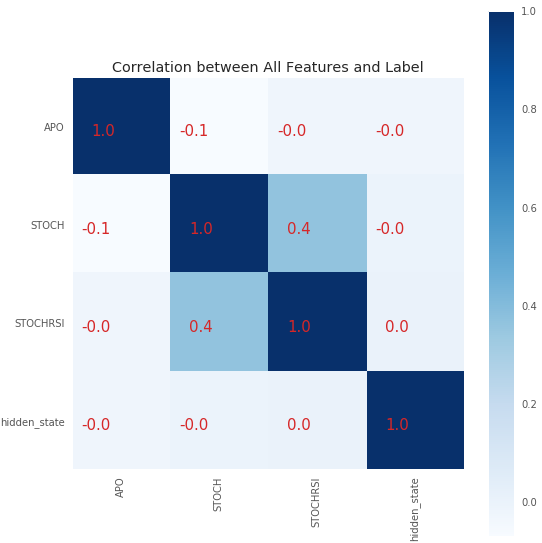

In [11]:
def plot_correlation_matrix(df, titl):
    plt.imshow(df.values, cmap=plt.cm.Blues)
    plt.xticks(range(df.shape[0]), df.columns, rotation='vertical')
    plt.yticks(range(df.shape[0]), df.columns)
    plt.title(titl)
    plt.colorbar()
    plt.grid(None)
    for i in range(0,df.shape[0]):
        for j in range(0, df.shape[0]):
            if df.values[i, j] < 0:
                plt.text(i-0.4, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=15);
            else:
                plt.text(i-0.3, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=15);
                
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(8,8))
    plot_correlation_matrix(dataset1.corr(), 'Correlation between All Features and Label')
                
    plt.tight_layout()
    
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    
    #plt.savefig(os.path.join(batch,"correlation.png"), dpi=200)


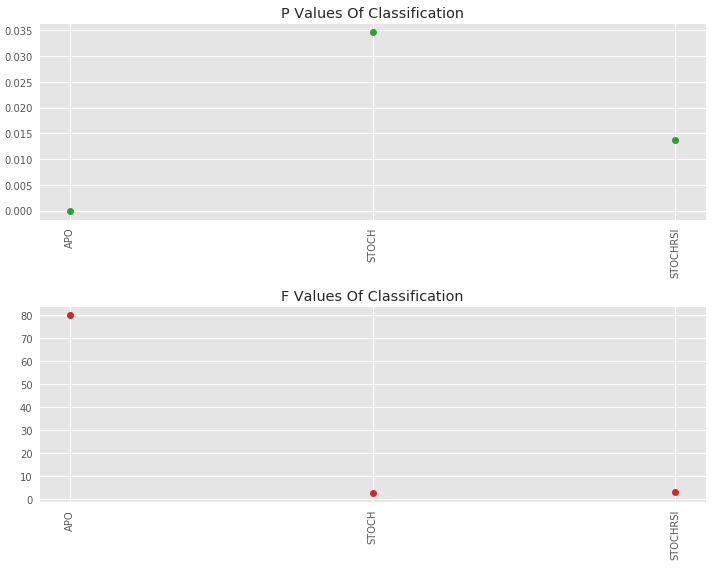

In [12]:
X = dataset1.drop(columns=["hidden_state", "Time"])
X = MinMaxScaler().fit_transform(X)
Y = dataset1['hidden_state'].values
#Y = np.array([1 if y==1 else 0 for y in Y])

cols = dataset1.drop(columns=["Time", "hidden_state"]).columns

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('P Values Of Classification')
    plt.subplot(212)
    plt.plot(F_classif, 'o', c = 'tab:red')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('F Values Of Classification');
    
    plt.tight_layout()
    
    #plt.savefig(os.path.join(batch,"f_p_values.png"), dpi=200)

### Hidden State Trend

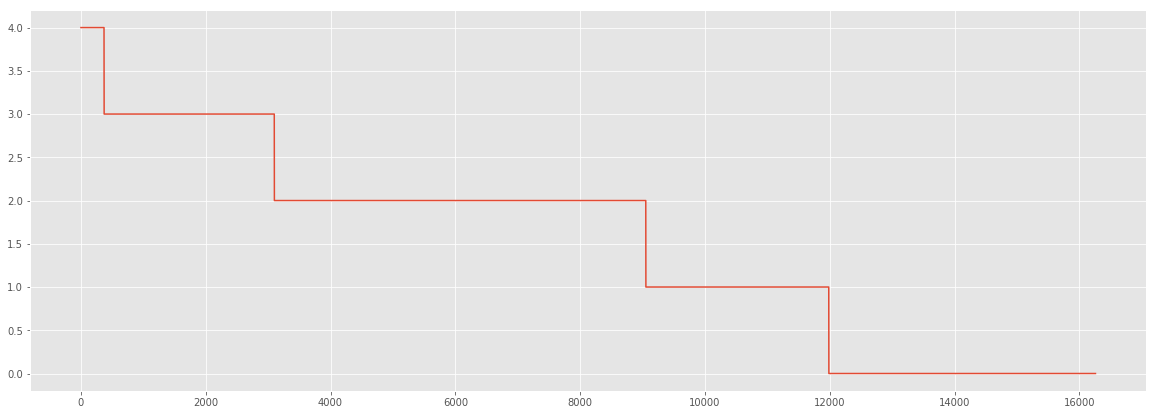

In [13]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(20,7))
    plt.plot(dataset1.hidden_state)

## ML/DL Algorithms

In [67]:
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        if "val_loss" in hist.history:
            plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            if "val_accuracy" in hist.history:
                plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')
            
def print_plot_metrics(model_name, Y_test, predictions):
    print('Classification Report : \n',classification_report(Y_test, predictions))
    conf_mat = confusion_matrix(Y_test, predictions)
    print('Confusion Matrix : \n', conf_mat)
    #plot_confusion_matrix(conf_mat)
    
def plot_confusion_matrix(conf_mat):
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(10,10))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.xticks([0, 1], [-1, 1])
        plt.yticks([0, 1], [-1, 1])
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                

In [68]:
batch = "BTCUSD_Dataset1"

if not os.path.exists(batch):
    os.mkdir(batch)

X = dataset1.drop(columns = ["hidden_state", "Time"]).values
Y = dataset1["hidden_state"].values

print("Are there any NA in dataset? : {}".format(not np.alltrue(np.any(X))))

X.shape, Y.shape

Are there any NA in dataset? : False


((16258, 3), (16258,))

### XGB Classifier

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    train_size=0.80,
                                                    stratify=Y                                                    
                                                    )

print("Train/Test Sizes : ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print("\nClass Distribution (Y_train) : ")
for cls in np.unique(Y_train):
    print("{} : {}".format(cls, Y_train.tolist().count(cls)))

print("\nClass Distribution (Y_test) : ")
for cls in np.unique(Y_test):
    print("{} : {}".format(cls, Y_test.tolist().count(cls)))

Y_train_cat, Y_test_cat = keras.utils.to_categorical(Y_train), keras.utils.to_categorical(Y_test)

Y_train_cat.shape, Y_test_cat.shape

Train/Test Sizes :  (13006, 3) (3252, 3) (13006,) (3252,)

Class Distribution (Y_train) : 
0 : 3419
1 : 2346
2 : 4762
3 : 2182
4 : 297

Class Distribution (Y_test) : 
0 : 855
1 : 586
2 : 1191
3 : 546
4 : 74


((13006, 5), (3252, 5))

In [70]:
xgb_classif = xgb.XGBClassifier(objective="multi:softmax", num_class=5)

xgb_classif.fit(X_train, Y_train, verbose=10)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [71]:
predictions = xgb_classif.predict(X_test)

print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))
print_plot_metrics('XGBClassifier', Y_test, predictions)

Accuracy : 0.746

Classification Report : 
               precision    recall  f1-score   support

           0       0.67      0.78      0.72       855
           1       0.58      0.39      0.47       586
           2       0.83      0.97      0.89      1191
           3       0.80      0.63      0.71       546
           4       0.71      0.39      0.50        74

    accuracy                           0.75      3252
   macro avg       0.72      0.63      0.66      3252
weighted avg       0.74      0.75      0.73      3252

Confusion Matrix : 
 [[ 664  126    1   63    1]
 [ 119  230  237    0    0]
 [   0   35 1156    0    0]
 [ 189    0    0  346   11]
 [  15    3    4   23   29]]


In [72]:
correct_preds = 0

for pred, actual in zip(predictions,Y_test):
    if pred == actual:
        correct_preds += 1
    else:
        diff = pred-actual
        diff = -1 * diff if diff < 0 else diff

        if diff==1:
            correct_preds += 1
        
print("Correct Predictions : {}/{}".format(correct_preds, len(predictions)))
print("Accuracy with new logic : {:,.3f}".format(correct_preds/len(predictions)))

Correct Predictions : 2976/3252
Accuracy with new logic : 0.915


Class Distribution in Last 20% samples : Counter({0: 3252})

Total SUM: 1.0 : Win Pct: 0.5279 : SQN: 3.7763
Total sum for state: 0 : 1.0
SQN for state: 0 : 3.7763

Total sum for state: 1 : 0.0173
SQN for state: 1 : 0.5337

Total sum for state: 2 : 0.0
SQN for state: 2 : nan

Total sum for state: 3 : 0.054
SQN for state: 3 : 1.5099

Total sum for state: 4 : -0.0011
SQN for state: 4 : -inf



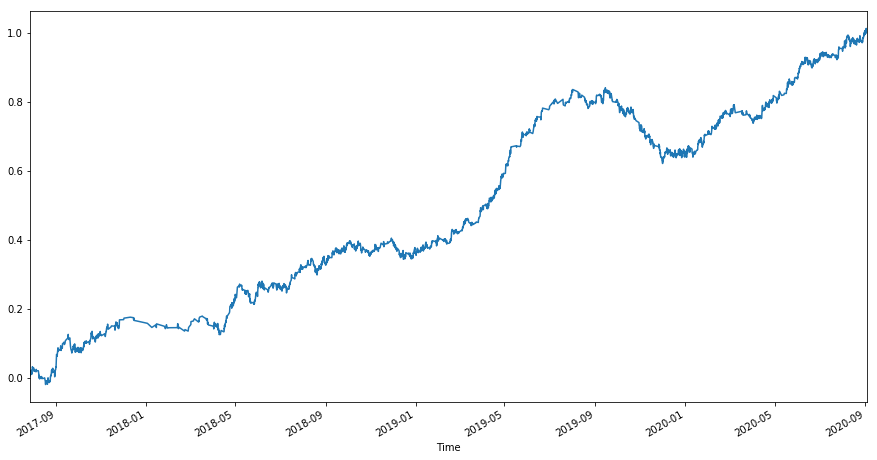

In [73]:
# Trading statistics 
### X_train and X_test has shuffled samples from dataset1. Samples in it can come from any position in dataset1.
### We don't know their indices.
### We can again take last samples of dataset and make prediction on them and use that predictions
## Because this way prediction and sample data will have same indices.

last_samples = dataset1.drop(columns = ["hidden_state", "Time"]).values[len(X_train):]
last_actual_targets = dataset1["hidden_state"].values[len(X_train):]
print("Class Distribution in Last 20% samples : {}\n".format(Counter(last_actual_targets)))

predictions = xgb_classif.predict(last_samples) ## New Predictions on original indices samples to avoid shuffling issue.

total_sum = open_close_change[len(X_train):][predictions == 0].sum()
win_pct = open_close_change[len(X_train):][predictions == 0].where(lambda x: x > 0).dropna().shape[0] / len(open_close_change[len(X_train):][predictions == 0])
sqn_score = sqn(open_close_change[len(X_train):][predictions == 0])

print('Total SUM: {} : Win Pct: {} : SQN: {}'.format(round(total_sum, 4), round(win_pct, 4), sqn_score))
for state in states:
    print('Total sum for state: {} : {}'.format(state, round(open_close_change[len(X_train):][predictions == state].sum(), 4)))
    print('SQN for state: {} : {}'.format(state, sqn(open_close_change[len(X_train):][predictions == state])))
    print('')
    
open_close_change[len(X_train):][predictions == 0].cumsum().plot(figsize = (15, 8))

### LIME Interpretation

In [74]:
import random
random.seed(123)

j = random.randint(0, X_test.shape[0])

pred = xgb_classif.predict(X_test[j:j+1])[0]

print("Actual Value : {}".format(Y_test[j]))
print("Prediction   : {}\n".format(pred))


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=dataset1.drop(columns=["Time", "hidden_state"]).columns,
                                                   #class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    xgb_classif.predict_proba, 
                                    labels=[0,1,2,3,4],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Actual Value : 1
Prediction   : 1

Intercept 0.20664521736747823
Prediction_local [0.10020412]
Right: 0.1257076
Intercept 0.0762288858904097
Prediction_local [0.34812885]
Right: 0.8618445
Intercept 0.26719537360813167
Prediction_local [0.56539275]
Right: 8.4153624e-05
Intercept 0.43400651772387266
Prediction_local [-0.02078491]
Right: 0.0008772312
Intercept 0.015924005969896404
Prediction_local [0.00705919]
Right: 0.011486596


### XGB RF Classifier

In [75]:
xgb_rf_classif = xgb.XGBRFClassifier(objective="multi:softmax", num_class=5)

xgb_rf_classif.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=10)

[0]	validation_0-merror:0.24416


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=1, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_class=5, num_parallel_tree=100,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                reg_lambda=1e-05, scale_pos_weight=None, subsample=0.8,
                tree_method='exact', validate_parameters=1, verbosity=None)

In [76]:
predictions = xgb_rf_classif.predict(X_test)

print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))
print_plot_metrics('XGBClassifier', Y_test, predictions)

Accuracy : 0.756

Classification Report : 
               precision    recall  f1-score   support

           0       0.66      0.87      0.75       855
           1       0.64      0.28      0.39       586
           2       0.82      0.99      0.90      1191
           3       0.87      0.63      0.73       546
           4       0.89      0.34      0.49        74

    accuracy                           0.76      3252
   macro avg       0.78      0.62      0.65      3252
weighted avg       0.76      0.76      0.73      3252

Confusion Matrix : 
 [[ 745   80    1   29    0]
 [ 170  164  252    0    0]
 [   0    9 1182    0    0]
 [ 201    0    0  342    3]
 [  19    2    5   23   25]]


In [77]:
correct_preds = 0

for pred, actual in zip(predictions,Y_test):
    if pred == actual:
        correct_preds += 1
    else:
        diff = pred-actual
        diff = -1 * diff if diff < 0 else diff

        if diff==1:
            correct_preds += 1
        
print("Correct Predictions : {}/{}".format(correct_preds, len(predictions)))
print("Accuracy with new logic : {:,.3f}".format(correct_preds/len(predictions)))

Correct Predictions : 2995/3252
Accuracy with new logic : 0.921


Class Distribution in Last 20% samples : Counter({0: 3252})

Total SUM: 1.022 : Win Pct: 0.5287 : SQN: 3.8484
Total sum for state: 0 : 1.022
SQN for state: 0 : 3.8484

Total sum for state: 1 : 0.0561
SQN for state: 1 : 1.8508

Total sum for state: 2 : 0.0013
SQN for state: 2 : inf

Total sum for state: 3 : -0.0093
SQN for state: 3 : -0.2927

Total sum for state: 4 : 0.0
SQN for state: 4 : nan



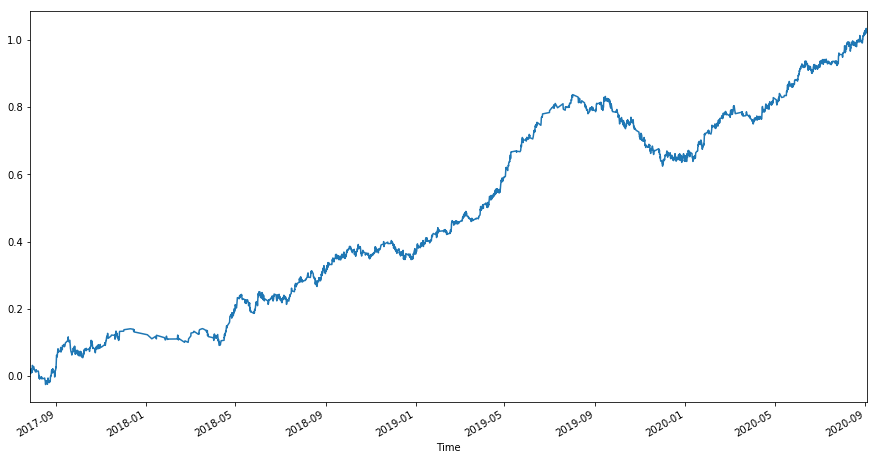

In [78]:
# Trading statistics 
### X_train and X_test has shuffled samples from dataset1. Samples in it can come from any position in dataset1.
### We don't know their indices.
### We can again take last samples of dataset and make prediction on them and use that predictions
## Because this way prediction and sample data will have same indices.

last_samples = dataset1.drop(columns = ["hidden_state", "Time"]).values[len(X_train):]
last_actual_targets = dataset1["hidden_state"].values[len(X_train):]
print("Class Distribution in Last 20% samples : {}\n".format(Counter(last_actual_targets)))

predictions = xgb_rf_classif.predict(last_samples) ## New Predictions on original indices

total_sum = open_close_change[len(X_train):][predictions == 0].sum()
win_pct = open_close_change[len(X_train):][predictions == 0].where(lambda x: x > 0).dropna().shape[0] / len(open_close_change[len(X_train):][predictions == 0])
sqn_score = sqn(open_close_change[len(X_train):][predictions == 0])

print('Total SUM: {} : Win Pct: {} : SQN: {}'.format(round(total_sum, 4), round(win_pct, 4), sqn_score))
for state in states:
    print('Total sum for state: {} : {}'.format(state, round(open_close_change[len(X_train):][predictions == state].sum(), 4)))
    print('SQN for state: {} : {}'.format(state, sqn(open_close_change[len(X_train):][predictions == state])))
    print('')
    
open_close_change[len(X_train):][predictions == 0].cumsum().plot(figsize = (15, 8))

### LIME Interpretation

In [79]:
import random
random.seed(123)

j = random.randint(0, X_test.shape[0])

pred = xgb_rf_classif.predict(X_test[j:j+1])[0]

print("Actual Value : {}".format(Y_test[j]))
print("Prediction   : {}\n".format(pred))


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=dataset1.drop(columns=["Time", "hidden_state"]).columns,
                                                   #class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    xgb_rf_classif.predict_proba, 
                                    labels=[0,1,2,3,4],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Actual Value : 1
Prediction   : 1

Intercept 0.20699509944973446
Prediction_local [0.11686199]
Right: 0.16504987
Intercept 0.08226273639412279
Prediction_local [0.24862107]
Right: 0.5870587
Intercept 0.28559658095766827
Prediction_local [0.48991571]
Right: 0.081072666
Intercept 0.3619450483399345
Prediction_local [0.07248692]
Right: 0.08273712
Intercept 0.06320053390316165
Prediction_local [0.0721143]
Right: 0.08408167


### Dense Nets

In [80]:
dense_model1 = Sequential([ 
                     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     #BatchNormalization(),      
                     Dropout(0.1),
                     Dense(64,  activation='relu'),
                     #BatchNormalization(),  
                     Dropout(0.1),
                     Dense(64,  activation='relu'),
                     #BatchNormalization(),  
                     Dropout(0.1),
                     Dense(32,  activation='relu'),
                     #BatchNormalization(),
                     Dropout(0.1),
                     Dense(5,   activation='softmax')])

print(dense_model1.summary())
#plot_model(dense_model1, to_file=os.path.join(batch, 'dense1.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'dense1.png'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               512       
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)               

In [81]:
dense_model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = dense_model1.fit(X_train, Y_train_cat, batch_size=32, epochs=100, verbose=1, use_multiprocessing=True);

Epoch 1/100
407/407 [==============================] - 0s 841us/step - loss: 1.2683 - accuracy: 0.5585
Epoch 2/100
407/407 [==============================] - 0s 759us/step - loss: 0.8478 - accuracy: 0.6683
Epoch 3/100
407/407 [==============================] - 0s 886us/step - loss: 0.7660 - accuracy: 0.6981
Epoch 4/100
407/407 [==============================] - 0s 844us/step - loss: 0.7278 - accuracy: 0.7062
Epoch 5/100
407/407 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.7214
Epoch 6/100
407/407 [==============================] - 0s 942us/step - loss: 0.6764 - accuracy: 0.7211
Epoch 7/100
407/407 [==============================] - 0s 884us/step - loss: 0.6639 - accuracy: 0.7247
Epoch 8/100
407/407 [==============================] - 0s 827us/step - loss: 0.6476 - accuracy: 0.7287
Epoch 9/100
407/407 [==============================] - 0s 747us/step - loss: 0.6464 - accuracy: 0.7316
Epoch 10/100
407/407 [==============================] - 0s 833us/step - los

407/407 [==============================] - 0s 686us/step - loss: 0.5707 - accuracy: 0.7506
Epoch 81/100
407/407 [==============================] - 0s 645us/step - loss: 0.5732 - accuracy: 0.7510
Epoch 82/100
407/407 [==============================] - 0s 642us/step - loss: 0.5672 - accuracy: 0.7505
Epoch 83/100
407/407 [==============================] - 0s 679us/step - loss: 0.5703 - accuracy: 0.7497
Epoch 84/100
407/407 [==============================] - 0s 661us/step - loss: 0.5676 - accuracy: 0.7494
Epoch 85/100
407/407 [==============================] - 0s 653us/step - loss: 0.5681 - accuracy: 0.7497
Epoch 86/100
407/407 [==============================] - 0s 639us/step - loss: 0.5696 - accuracy: 0.7475
Epoch 87/100
407/407 [==============================] - 0s 679us/step - loss: 0.5712 - accuracy: 0.7495
Epoch 88/100
407/407 [==============================] - 0s 644us/step - loss: 0.5723 - accuracy: 0.7491
Epoch 89/100
407/407 [==============================] - 0s 859us/step - loss:

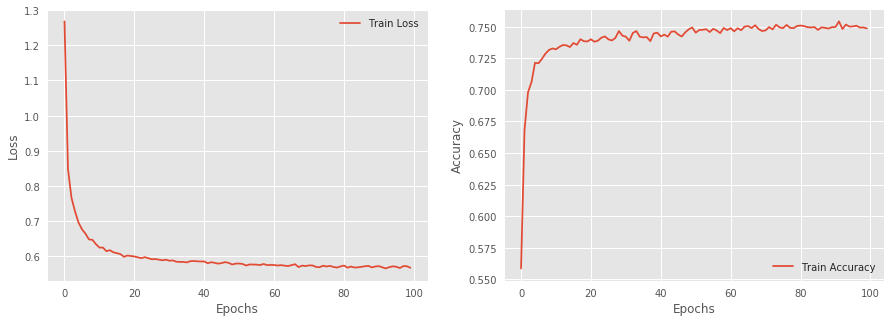

In [82]:
plot_loss_and_accuracy(history)

In [83]:
predictions = np.argmax(dense_model1.predict(X_test), axis=-1)
print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))

print_plot_metrics('DenseNetv1', Y_test, predictions)

Accuracy : 0.749

Classification Report : 
               precision    recall  f1-score   support

           0       0.66      0.84      0.74       855
           1       0.60      0.37      0.46       586
           2       0.82      0.98      0.90      1191
           3       0.87      0.59      0.70       546
           4       1.00      0.11      0.20        74

    accuracy                           0.75      3252
   macro avg       0.79      0.58      0.60      3252
weighted avg       0.75      0.75      0.73      3252

Confusion Matrix : 
 [[ 717  126    2   10    0]
 [ 121  218  247    0    0]
 [   0   18 1173    0    0]
 [ 225    0    0  321    0]
 [  19    2    5   40    8]]


In [84]:
correct_preds = 0

for pred, actual in zip(predictions,Y_test):
    if pred == actual:
        correct_preds += 1
    else:
        diff = pred-actual
        diff = -1 * diff if diff < 0 else diff

        if diff==1:
            correct_preds += 1
        
print("Correct Predictions : {}/{}".format(correct_preds, len(predictions)))
print("Accuracy with new logic : {:,.3f}".format(correct_preds/len(predictions)))

Correct Predictions : 2989/3252
Accuracy with new logic : 0.919


Class Distribution in Last 20% samples : Counter({0: 3252})

Total SUM: 0.9846 : Win Pct: 0.5302 : SQN: 3.713
Total sum for state: 0 : 0.9846
SQN for state: 0 : 3.713

Total sum for state: 1 : 0.0909
SQN for state: 1 : 2.0639

Total sum for state: 2 : 0.0
SQN for state: 2 : nan

Total sum for state: 3 : -0.0054
SQN for state: 3 : -0.3795

Total sum for state: 4 : 0.0
SQN for state: 4 : nan



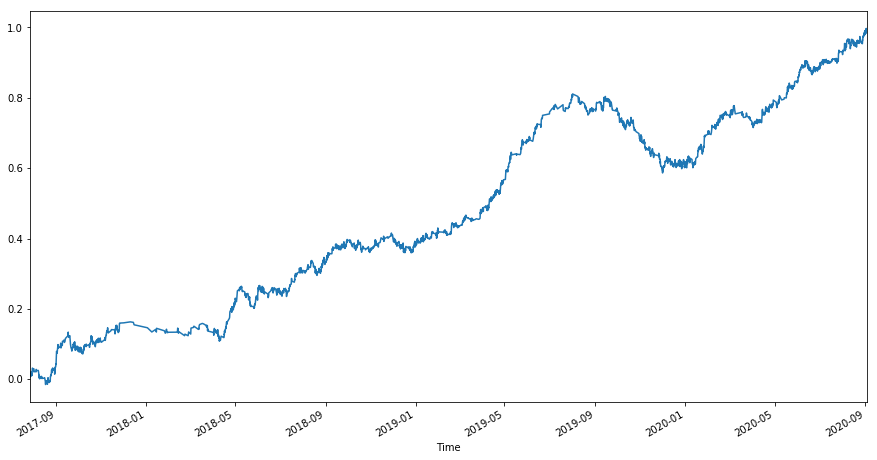

In [85]:
# Trading statistics 
### X_train and X_test has shuffled samples from dataset1. Samples in it can come from any position in dataset1.
### We don't know their indices.
### We can again take last samples of dataset and make prediction on them and use that predictions
## Because this way prediction and sample data will have same indices.

last_samples = dataset1.drop(columns = ["hidden_state", "Time"]).values[len(X_train):]
last_actual_targets = dataset1["hidden_state"].values[len(X_train):]
print("Class Distribution in Last 20% samples : {}\n".format(Counter(last_actual_targets)))

predictions = predictions = np.argmax(dense_model1.predict(last_samples), axis=-1) ## New Predictions on original indices

total_sum = open_close_change[len(X_train):][predictions == 0].sum()
win_pct = open_close_change[len(X_train):][predictions == 0].where(lambda x: x > 0).dropna().shape[0] / len(open_close_change[len(X_train):][predictions == 0])
sqn_score = sqn(open_close_change[len(X_train):][predictions == 0])

print('Total SUM: {} : Win Pct: {} : SQN: {}'.format(round(total_sum, 4), round(win_pct, 4), sqn_score))
for state in states:
    print('Total sum for state: {} : {}'.format(state, round(open_close_change[len(X_train):][predictions == state].sum(), 4)))
    print('SQN for state: {} : {}'.format(state, sqn(open_close_change[len(X_train):][predictions == state])))
    print('')
    
open_close_change[len(X_train):][predictions == 0].cumsum().plot(figsize = (15, 8))

### LIME Interpretation

In [86]:
import random
random.seed(123)

j = random.randint(0, X_test.shape[0])

pred = dense_model1.predict_classes(X_test[j:j+1])[0]

print("Actual Value : {}".format(Y_test[j]))
print("Prediction   : {}\n".format(pred))


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=dataset1.drop(columns=["Time", "hidden_state"]).columns,
                                                   #class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    dense_model1.predict_proba, 
                                    labels=[0,1,2,3,4],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Actual Value : 1
Prediction   : 1

Instructions for updating:
Please use `model.predict()` instead.
Intercept 0.24093025624849443
Prediction_local [0.08647527]
Right: 0.35708266
Intercept 0.06642372872585306
Prediction_local [0.33757377]
Right: 0.62912554
Intercept 0.27984547947977956
Prediction_local [0.58090225]
Right: 0.0033533142
Intercept 0.3949907757356623
Prediction_local [-0.0093387]
Right: 8.547856e-06
Intercept 0.017809761195771115
Prediction_local [0.00438741]
Right: 0.010429924


### KMeans

In [87]:
from sklearn.cluster import KMeans

In [88]:
kmeans = KMeans(n_clusters=5)

kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [94]:
kmeans.fit(X_train, Y_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [95]:

predictions = kmeans.predict(X_test)
print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))

print_plot_metrics('DenseNetv1', Y_test, predictions)

Accuracy : 0.213

Classification Report : 
               precision    recall  f1-score   support

           0       0.26      0.78      0.39       855
           1       0.00      0.00      0.00       586
           2       0.00      0.00      0.00      1191
           3       0.43      0.03      0.05       546
           4       0.02      0.09      0.04        74

    accuracy                           0.21      3252
   macro avg       0.14      0.18      0.10      3252
weighted avg       0.14      0.21      0.11      3252

Confusion Matrix : 
 [[ 671    0   45    0  139]
 [ 586    0    0    0    0]
 [1191    0    0    0    0]
 [ 131   70  157   15  173]
 [  21   18    8   20    7]]


In [96]:
correct_preds = 0

for pred, actual in zip(predictions,Y_test):
    if pred == actual:
        correct_preds += 1
    else:
        diff = pred-actual
        diff = -1 * diff if diff < 0 else diff

        if diff==1:
            correct_preds += 1
        
print("Correct Predictions : {}/{}".format(correct_preds, len(predictions)))
print("Accuracy with new logic : {:,.3f}".format(correct_preds/len(predictions)))

Correct Predictions : 1629/3252
Accuracy with new logic : 0.501


Class Distribution in Last 20% samples : Counter({0: 3252})

Total SUM: 0.9108 : Win Pct: 0.5338 : SQN: 3.9651
Total sum for state: 0 : 0.9108
SQN for state: 0 : 3.9651

Total sum for state: 1 : 0.0
SQN for state: 1 : nan

Total sum for state: 2 : 0.0951
SQN for state: 2 : 1.86

Total sum for state: 3 : 0.0
SQN for state: 3 : nan

Total sum for state: 4 : 0.0642
SQN for state: 4 : 0.4917



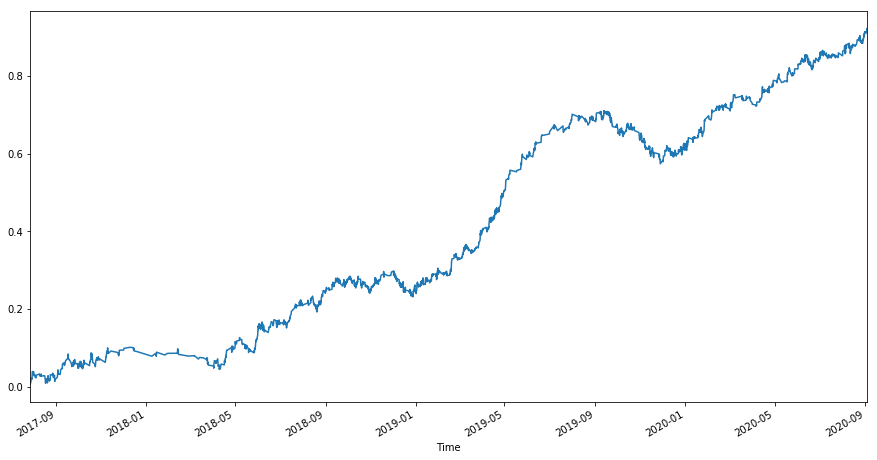

In [97]:
# Trading statistics 
### X_train and X_test has shuffled samples from dataset1. Samples in it can come from any position in dataset1.
### We don't know their indices.
### We can again take last samples of dataset and make prediction on them and use that predictions
## Because this way prediction and sample data will have same indices.

last_samples = dataset1.drop(columns = ["hidden_state", "Time"]).values[len(X_train):]
last_actual_targets = dataset1["hidden_state"].values[len(X_train):]
print("Class Distribution in Last 20% samples : {}\n".format(Counter(last_actual_targets)))

predictions = kmeans.predict(last_samples) ## New Predictions on original indices

total_sum = open_close_change[len(X_train):][predictions == 0].sum()
win_pct = open_close_change[len(X_train):][predictions == 0].where(lambda x: x > 0).dropna().shape[0] / len(open_close_change[len(X_train):][predictions == 0])
sqn_score = sqn(open_close_change[len(X_train):][predictions == 0])

print('Total SUM: {} : Win Pct: {} : SQN: {}'.format(round(total_sum, 4), round(win_pct, 4), sqn_score))
for state in states:
    print('Total sum for state: {} : {}'.format(state, round(open_close_change[len(X_train):][predictions == state].sum(), 4)))
    print('SQN for state: {} : {}'.format(state, sqn(open_close_change[len(X_train):][predictions == state])))
    print('')
    
open_close_change[len(X_train):][predictions == 0].cumsum().plot(figsize = (15, 8))